3dB Bandwidth = 0.9891 GHz
10dB Bandwidth = 1.6363 GHz
Shape Factor (10dB/3dB) = 1.6543


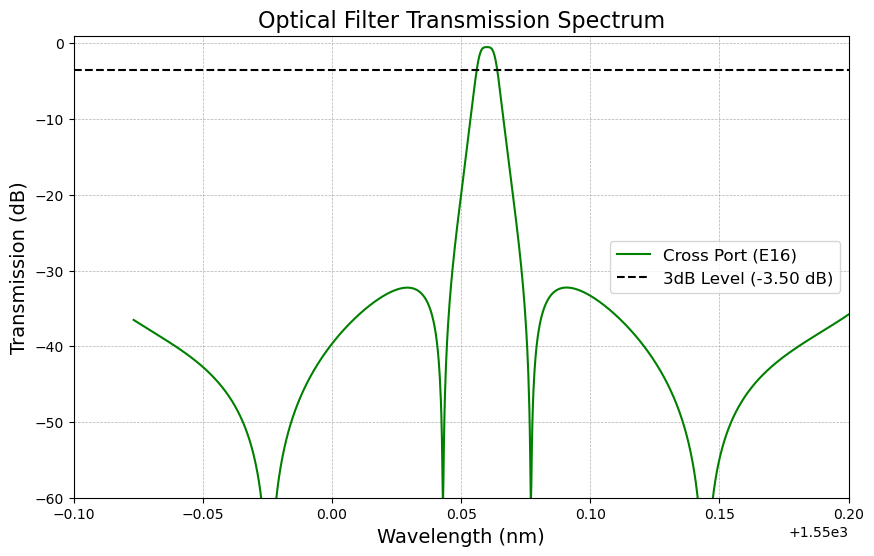

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 初始化 ---
# 定义频率范围
f = np.arange(1.93523e14, 1.93558e14, 0.00000025e14)
c = 3e8  # 光速

# 输入电场
E1 = 0
E2 = 1

# --- 器件参数 ---
# 耦合器系数
Ki = 0.5  # 输入3dB耦合器
Ko = 0.5  # 输出3dB耦合器

# MZI相移
thetai = 0.5 * np.pi
thetao = 0.5 * np.pi
fait = 0.495 * np.pi   # MZI上臂相移
faib = -0.495 * np.pi  # MZI下臂相移

# 微环静态相移
fai1 = -0.0468 * np.pi
fai2 = -0.6842 * np.pi
fai3 = -0.0518 * np.pi
fai4 = -0.6198 * np.pi

# 与微环级联的MZI耦合器相移
theta1 = -0.622 * np.pi
theta2 = -0.73 * np.pi
theta3 = -0.622 * np.pi
theta4 = -0.73 * np.pi

# 材料和物理属性
Alfadb = 15  # 功率损耗因子 (dB/m)
neff = 2.2998  # 有效折射率
ng = 4.3  # 群折射率
L1 = 350e-6
L3 = 350e-6
L2 = 3000e-6
L4 = 3000e-6

# --- 初步计算 ---
# 将功率损耗转换为场强损耗
alfadb = Alfadb / 2
alfa = alfadb * np.log(10) / 10

# 每个环的场强传输损耗
tao1 = np.exp(-alfa * L1)
tao2 = np.exp(-alfa * L2)
tao3 = np.exp(-alfa * L3)
tao4 = np.exp(-alfa * L4)

# --- 核心仿真 (矢量化) ---
# 每个环的频率相关相移
fai11 = 2 * np.pi * f * L1 * ng / c
fai22 = 2 * np.pi * f * L2 * ng / c
fai33 = 2 * np.pi * f * L3 * ng / c
fai44 = 2 * np.pi * f * L4 * ng / c

# 1. 输入MZI
E3 = np.sqrt(1 - Ki) * E1 - 1j * np.sqrt(Ki) * E2
E4 = -1j * np.sqrt(Ki) * E1 + np.sqrt(1 - Ki) * E2
E5 = E3
E6 = np.exp(1j * thetai) * E4
E7 = np.sqrt(1 - Ki) * E5 - 1j * np.sqrt(Ki) * E6
E8 = -1j * np.sqrt(Ki) * E5 + np.sqrt(1 - Ki) * E6

# 2. 带有微环谐振器的平行臂
# 每个环的传输函数 (一次性计算所有频率)
c1 = ((np.exp(1j * theta1) - 1) / 2 - tao1 * np.exp(1j * (fai1 + theta1 + fai11))) / \
     (1 - tao1 * (1 - np.exp(1j * theta1)) * np.exp(1j * (fai11 + fai1)) / 2)
c2 = ((np.exp(1j * theta2) - 1) / 2 - tao2 * np.exp(1j * (fai2 + theta2 + fai22))) / \
     (1 - tao2 * (1 - np.exp(1j * theta2)) * np.exp(1j * (fai22 + fai2)) / 2)
c3 = ((np.exp(1j * theta3) - 1) / 2 - tao3 * np.exp(1j * (fai3 + theta3 + fai33))) / \
     (1 - tao3 * (1 - np.exp(1j * theta3)) * np.exp(1j * (fai33 + fai3)) / 2)
c4 = ((np.exp(1j * theta4) - 1) / 2 - tao4 * np.exp(1j * (fai4 + theta4 + fai44))) / \
     (1 - tao4 * (1 - np.exp(1j * theta4)) * np.exp(1j * (fai44 + fai4)) / 2)

# 每条臂的总传输函数
A1 = np.exp(1j * fait) * c1 * c2
A2 = np.exp(1j * faib) * c3 * c4

# 通过平行臂后的场
E9 = A1 * E7
E10 = A2 * E8

# 3. 输出MZI
E11 = np.sqrt(1 - Ko) * E9 - 1j * np.sqrt(Ko) * E10
E12 = -1j * np.sqrt(Ko) * E9 + np.sqrt(1 - Ko) * E10
E13 = E11
E14 = np.exp(1j * thetao) * E12
E15 = np.sqrt(1 - Ko) * E13 - 1j * np.sqrt(Ko) * E14
E16 = -1j * np.sqrt(Ko) * E13 + np.sqrt(1 - Ko) * E14

# 计算功率并转换为dB
C2 = np.abs(E16)**2
CdB2 = 10 * np.log10(C2)

# --- 后处理与绘图 ---
# 将频率转换为波长 (nm)
lambda_nm = (c / f) * 1e9

# 创建绘图
plt.figure(figsize=(10, 6))
plt.plot(lambda_nm, CdB2, 'g', label='Cross Port (E16)')

# --- 带宽计算 ---
# 寻找透射峰值
y_max = np.max(CdB2)
x_max_idx = np.argmax(CdB2)

# 定义一个通过插值法寻找带宽的函数
def find_bandwidth(x_data, y_data, peak_y, peak_x_idx, level_db):
    y_level = peak_y - level_db
    left_x = x_data[:peak_x_idx + 1]
    left_y = y_data[:peak_x_idx + 1]
    right_x = x_data[peak_x_idx:]
    right_y = y_data[peak_x_idx:]
    
    # 使用插值法在两侧找到精确的交叉点
    x_level_l = np.interp(y_level, left_y, left_x)
    x_level_h = np.interp(y_level, right_y[::-1], right_x[::-1])
    
    return x_level_l, x_level_h

# 计算3dB带宽
y_3db_level = y_max - 3
x_3db_l, x_3db_h = find_bandwidth(lambda_nm, CdB2, y_max, x_max_idx, 3)
fq_3db_l = c / (x_3db_l * 1e-9)
fq_3db_h = c / (x_3db_h * 1e-9)
three_db_width = abs(fq_3db_h - fq_3db_l)

# 计算10dB带宽
y_10db_level = y_max - 10
x_10db_l, x_10db_h = find_bandwidth(lambda_nm, CdB2, y_max, x_max_idx, 10)
fq_10db_l = c / (x_10db_l * 1e-9)
fq_10db_h = c / (x_10db_h * 1e-9)
ten_db_width = abs(fq_10db_h - fq_10db_l)

# 计算矩形因子
SF_10db = ten_db_width / three_db_width

print(f"3dB Bandwidth = {three_db_width / 1e9:.4f} GHz")
print(f"10dB Bandwidth = {ten_db_width / 1e9:.4f} GHz")
print(f"Shape Factor (10dB/3dB) = {SF_10db:.4f}")

# --- 绘图格式化 ---
plt.axhline(y=y_3db_level, color='k', linestyle='--', label=f'3dB Level ({y_3db_level:.2f} dB)')
plt.title('Optical Filter Transmission Spectrum', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Transmission (dB)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axis([1549.9, 1550.2, -60, 1])
plt.show()

--- 初始参数性能 ---
初始代价值: 1724.5032

--- 正在使用Scipy进行优化... ---
  当前代价值: 516.5045
  当前代价值: 465.2129


/root/anaconda3/envs/OptD/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/OptD/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  当前代价值: 361.9382
  当前代价值: 341.5748
  当前代价值: 323.0983
  当前代价值: 314.1464

--- 优化完成 ---
优化是否成功: False
最终代价值: 806.7582773699904
找到的最优参数:
  fai1: -0.072319
  fai2: -1.997719
  fai3: -0.247328
  fai4: -1.981931
  theta1: -1.818896
  theta2: -2.126028
  theta3: -1.979753
  theta4: -2.328252

--- 正在生成对比图... ---


/root/anaconda3/envs/OptD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28388 (\N{CJK UNIFIED IDEOGRAPH-6EE4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/anaconda3/envs/OptD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/anaconda3/envs/OptD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22120 (\N{CJK UNIFIED IDEOGRAPH-5668}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/anaconda3/envs/OptD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21709 (\N{CJK UNIFIED IDEOGRAPH-54CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/anaconda3/envs/OptD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24212 (\N{

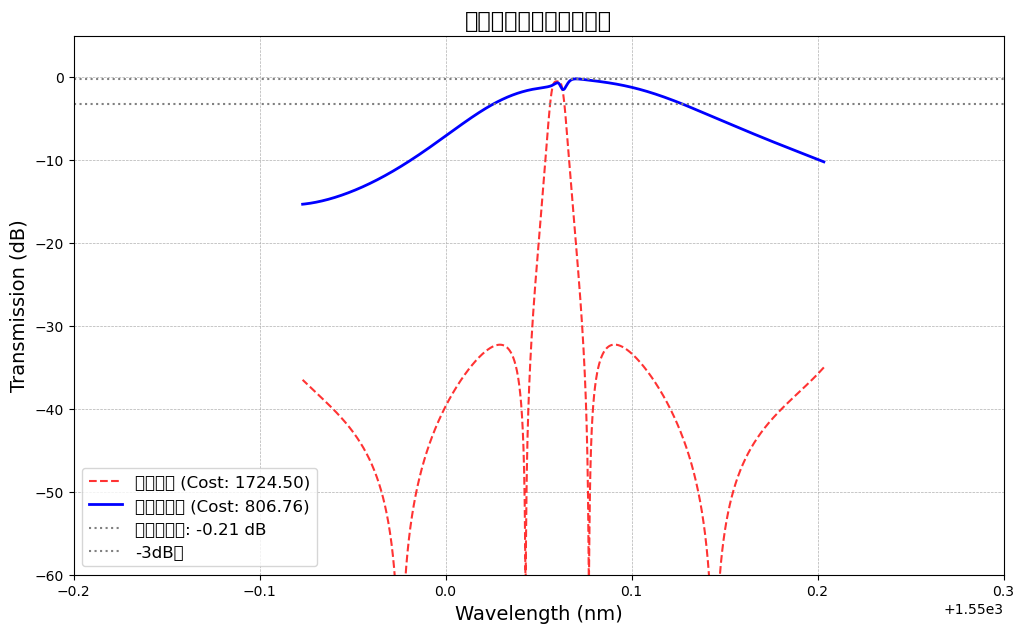

In [2]:
# ### 1. 导入所有必要的库 ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ### 2. 核心仿真函数 ###
# 将您的仿真代码封装成一个函数，方便在优化过程中反复调用
def run_simulation(params, static_params):
    """
    运行光学滤波器仿真。
    
    Args:
        params (list or np.array): 包含8个待优化参数的数组 [fai1, ..., theta4]。
        static_params (dict): 包含所有固定参数的字典。

    Returns:
        tuple: (波长数组, dB透射率数组)
    """
    # 解包固定参数
    f = static_params['f']
    c = static_params['c']
    E1, E2 = 0, 1
    Ki, Ko = 0.5, 0.5
    thetai, thetao = 0.5 * np.pi, 0.5 * np.pi
    fait, faib = 0.495 * np.pi, -0.495 * np.pi
    Alfadb, ng = 15, 4.3
    L1, L2, L3, L4 = 350e-6, 3000e-6, 350e-6, 3000e-6

    # 解包待优化参数
    fai1, fai2, fai3, fai4, theta1, theta2, theta3, theta4 = params

    # 初步计算
    alfa = (Alfadb / 2) * np.log(10) / 10
    tao1, tao2, tao3, tao4 = np.exp(-alfa * L1), np.exp(-alfa * L2), np.exp(-alfa * L3), np.exp(-alfa * L4)

    # 核心仿真
    fai11 = 2*np.pi*f*L1*ng/c
    fai22 = 2*np.pi*f*L2*ng/c
    fai33 = 2*np.pi*f*L3*ng/c
    fai44 = 2*np.pi*f*L4*ng/c
    
    E3 = np.sqrt(1-Ki)*E1 - 1j*np.sqrt(Ki)*E2
    E4 = -1j*np.sqrt(Ki)*E1 + np.sqrt(1-Ki)*E2
    E5 = E3
    E6 = np.exp(1j*thetai)*E4
    E7 = np.sqrt(1-Ki)*E5 - 1j*np.sqrt(Ki)*E6
    E8 = -1j*np.sqrt(Ki)*E5 + np.sqrt(1-Ki)*E6
    
    c1 = ((np.exp(1j*theta1)-1)/2 - tao1*np.exp(1j*(fai1+theta1+fai11))) / (1-tao1*(1-np.exp(1j*theta1))*np.exp(1j*(fai11+fai1))/2)
    c2 = ((np.exp(1j*theta2)-1)/2 - tao2*np.exp(1j*(fai2+theta2+fai22))) / (1-tao2*(1-np.exp(1j*theta2))*np.exp(1j*(fai22+fai2))/2)
    c3 = ((np.exp(1j*theta3)-1)/2 - tao3*np.exp(1j*(fai3+theta3+fai33))) / (1-tao3*(1-np.exp(1j*theta3))*np.exp(1j*(fai33+fai3))/2)
    c4 = ((np.exp(1j*theta4)-1)/2 - tao4*np.exp(1j*(fai4+theta4+fai44))) / (1-tao4*(1-np.exp(1j*theta4))*np.exp(1j*(fai44+fai4))/2)
    
    A1 = np.exp(1j*fait)*c1*c2
    A2 = np.exp(1j*faib)*c3*c4
    
    E9 = A1*E7
    E10 = A2*E8
    
    E11 = np.sqrt(1-Ko)*E9 - 1j*np.sqrt(Ko)*E10
    E12 = -1j*np.sqrt(Ko)*E9 + np.sqrt(1-Ko)*E10
    E13 = E11
    E14 = np.exp(1j*thetao)*E12
    E15 = np.sqrt(1-Ko)*E13 - 1j*np.sqrt(Ko)*E14
    E16 = -1j*np.sqrt(Ko)*E13 + np.sqrt(1-Ko)*E14
    
    # 增加一个小的epsilon防止log10(0)
    C2 = np.abs(E16)**2 + 1e-12
    CdB2 = 10 * np.log10(C2)
    lambda_nm = (c / f) * 1e9
    
    return lambda_nm, CdB2

# ### 3. 代价函数定义 ###
def cost_function(params, static_params, targets, weights):
    """
    计算给定参数下的代价值。
    """
    lambda_nm, CdB2 = run_simulation(params, static_params)
    c = static_params['c']

    # --- 分析仿真结果 ---
    peak_val = np.max(CdB2)
    peak_idx = np.argmax(CdB2)
    peak_lambda = lambda_nm[peak_idx]

    target_bw_nm = targets['bandwidth_ghz'] * 1e9 * targets['center_wavelength_nm']**2 / c
    passband_mask = np.abs(lambda_nm - peak_lambda) <= (target_bw_nm / 2)
    stopband_mask = np.abs(lambda_nm - peak_lambda) > (2 * target_bw_nm)

    # --- 计算各项惩罚值 ---
    penalty_loss = (-peak_val)**2 if peak_val < 0 else 0
    
    passband_db = CdB2[passband_mask]
    penalty_ripple = np.max(passband_db) - np.min(passband_db) if passband_db.size > 0 else 100

    try:
        def find_bw_points(x_data, y_data, peak_y, peak_x_idx, level_db):
            y_level = peak_y - level_db
            # 确保y_data在插值范围内是单调的
            left_y = y_data[:peak_x_idx + 1]
            right_y = y_data[peak_x_idx:]
            # 防止插值点超出范围
            if y_level < min(left_y) or y_level < min(right_y):
                raise ValueError("Level is below data range")
            x_level_l = np.interp(y_level, left_y, x_data[:peak_x_idx + 1])
            x_level_h = np.interp(y_level, right_y[::-1], x_data[peak_x_idx:][::-1])
            return x_level_l, x_level_h
        
        x_3db_l, x_3db_h = find_bw_points(lambda_nm, CdB2, peak_val, peak_idx, 3)
        actual_bw_ghz = abs(c / (x_3db_l * 1e-9) - c / (x_3db_h * 1e-9)) / 1e9
        
        penalty_bw_error = ((actual_bw_ghz - targets['bandwidth_ghz']) / targets['bandwidth_ghz'])**2
        penalty_cf_error = ((peak_lambda - targets['center_wavelength_nm']) / target_bw_nm)**2
    except:
        actual_bw_ghz = 0
        penalty_bw_error = 100
        penalty_cf_error = 100

    try:
        x_10db_l, x_10db_h = find_bw_points(lambda_nm, CdB2, peak_val, peak_idx, 10)
        actual_10db_bw_ghz = abs(c / (x_10db_l * 1e-9) - c / (x_10db_h * 1e-9)) / 1e9
        shape_factor = actual_10db_bw_ghz / actual_bw_ghz if actual_bw_ghz > 0 else 100
        penalty_shape_factor = (shape_factor - 1)**2
    except:
        penalty_shape_factor = 100

    avg_rejection = np.mean(CdB2[stopband_mask]) if stopband_mask.size > 0 else 0
    penalty_rejection = max(0, avg_rejection - targets['rejection_db'])
        
    total_cost = (weights['insertion_loss'] * penalty_loss +
                  weights['ripple'] * penalty_ripple +
                  weights['bw_error'] * penalty_bw_error +
                  weights['cf_error'] * penalty_cf_error +
                  weights['shape_factor'] * penalty_shape_factor +
                  weights['rejection'] * penalty_rejection)
    
    return total_cost

# ### 4. 优化执行与可视化 ###

# --- 配置您的目标和权重 ---
TARGETS = {
    'center_wavelength_nm': 1550.05,
    'bandwidth_ghz': 25.0,
    'rejection_db': -40.0
}
WEIGHTS = {
    'insertion_loss': 50.0,
    'ripple': 20.0,
    'bw_error': 10.0,
    'cf_error': 10.0,
    'shape_factor': 5.0,
    'rejection': 1.0
}

# --- 准备优化 ---
# 定义固定的仿真参数
static_params = {
    'f': np.arange(1.93523e14, 1.93558e14, 0.0000001e14), # 增加采样点以提高精度
    'c': 3e8
}

# 设置优化的初始猜测值 (从您的代码中获取)
initial_params = [
    -0.0468 * np.pi, -0.6842 * np.pi, -0.0518 * np.pi, -0.6198 * np.pi,
    -0.622 * np.pi, -0.73 * np.pi, -0.622 * np.pi, -0.73 * np.pi
]

# 定义参数的边界 (推荐)
bounds = [(-np.pi, np.pi)] * 8

# --- 运行优化前，先看下初始效果 ---
print("--- 初始参数性能 ---")
lambda_nm_initial, CdB2_initial = run_simulation(initial_params, static_params)
initial_cost = cost_function(initial_params, static_params, TARGETS, WEIGHTS)
print(f"初始代价值: {initial_cost:.4f}")

# --- 开始优化 ---
print("\n--- 正在使用Scipy进行优化... ---")
# 定义一个回调函数来打印每一次迭代的代价值
def callback_function(xk):
    cost = cost_function(xk, static_params, TARGETS, WEIGHTS)
    print(f"  当前代价值: {cost:.4f}")

result = minimize(
    fun=cost_function,
    x0=initial_params,
    args=(static_params, TARGETS, WEIGHTS),
    method='L-BFGS-B',
    bounds=bounds,
    callback=callback_function,
    options={'disp': True, 'maxiter': 100} # 减少迭代次数以加快演示
)

# --- 显示优化结果 ---
print("\n--- 优化完成 ---")
print(f"优化是否成功: {result.success}")
print(f"最终代价值: {result.fun}")
print("找到的最优参数:")
optimized_params = result.x
param_names = ['fai1', 'fai2', 'fai3', 'fai4', 'theta1', 'theta2', 'theta3', 'theta4']
for name, val in zip(param_names, optimized_params):
    print(f"  {name}: {val:.6f}")

# --- 可视化对比 ---
print("\n--- 正在生成对比图... ---")
lambda_nm_opt, CdB2_opt = run_simulation(optimized_params, static_params)

plt.figure(figsize=(12, 7))
plt.plot(lambda_nm_initial, CdB2_initial, 'r--', label=f'初始响应 (Cost: {initial_cost:.2f})', alpha=0.8)
plt.plot(lambda_nm_opt, CdB2_opt, 'b-', label=f'优化后响应 (Cost: {result.fun:.2f})', linewidth=2)

# 绘制目标线
peak_opt = np.max(CdB2_opt)
plt.axhline(y=peak_opt, color='gray', linestyle=':', label=f'优化后峰值: {peak_opt:.2f} dB')
plt.axhline(y=peak_opt - 3, color='gray', linestyle=':', label='-3dB线')

plt.title('滤波器响应优化前后对比', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Transmission (dB)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(-60, 5)
plt.xlim(1549.8, 1550.3) # 可根据需要调整范围
plt.show()

--- Initial Parameters Performance ---
Initial Cost: 17096.9930

--- Starting 8-Parameter Optimization with Scipy... ---

--- Optimization Finished ---
Success: True
Final Cost: 9952.482500614133
Optimal Parameters Found (8 values):
  fai1: 1.869407
  fai2: 1.081733
  fai3: -2.068688
  fai4: -2.599104
  theta1: -2.563254
  theta2: 1.095565
  theta3: -2.697120
  theta4: -2.784603

--- Generating Comparison Plot... ---


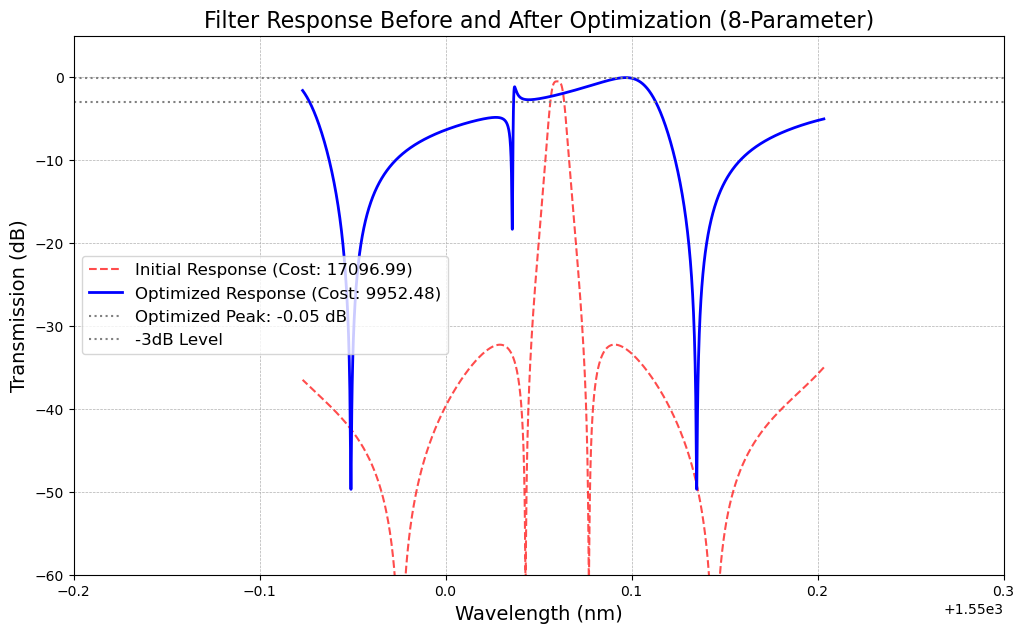

In [9]:
# === SECTION 1: IMPORTS AND SETUP ===

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Configuration: Define your targets and weights here ---
# This is the main section for user adjustments.
TARGETS = {
    'center_wavelength_nm': 1550.05,
    'bandwidth_ghz': 25.0,
    'rejection_db': -40.0
}

WEIGHTS = {
    'insertion_loss': 10.0,
    'ripple': 200.0,
    'bw_error': 50.0,
    'cf_error': 50.0,
    'shape_factor': 100.0,
    'rejection': 5.0
}


# === SECTION 2: CORE SIMULATION FUNCTION ===

def run_simulation(params, static_params):
    """
    Run the optical filter simulation.
    This function takes the parameters and simulates the physical response.
    """
    # --- Unpack parameters ---
    f = static_params['f']
    c = static_params['c']
    fai1, fai2, fai3, fai4, theta1, theta2, theta3, theta4 = params
    
    # Unpack fixed device properties
    E1, E2 = 0, 1
    Ki, Ko = 0.5, 0.5
    thetai, thetao = 0.5 * np.pi, 0.5 * np.pi
    fait, faib = 0.495 * np.pi, -0.495 * np.pi
    Alfadb, ng = 15, 4.3
    L1, L2, L3, L4 = 350e-6, 3000e-6, 350e-6, 3000e-6

    # --- Preliminary calculations ---
    alfa = (Alfadb / 2) * np.log(10) / 10
    tao1 = np.exp(-alfa * L1)
    tao2 = np.exp(-alfa * L2)
    tao3 = np.exp(-alfa * L3)
    tao4 = np.exp(-alfa * L4)

    # --- Core simulation logic ---
    fai11 = 2 * np.pi * f * L1 * ng / c
    fai22 = 2 * np.pi * f * L2 * ng / c
    fai33 = 2 * np.pi * f * L3 * ng / c
    fai44 = 2 * np.pi * f * L4 * ng / c
    
    E3 = np.sqrt(1 - Ki) * E1 - 1j * np.sqrt(Ki) * E2
    E4 = -1j * np.sqrt(Ki) * E1 + np.sqrt(1 - Ki) * E2
    
    E5 = E3
    E6 = np.exp(1j * thetai) * E4
    
    E7 = np.sqrt(1 - Ki) * E5 - 1j * np.sqrt(Ki) * E6
    E8 = -1j * np.sqrt(Ki) * E5 + np.sqrt(1 - Ki) * E6
    
    # Nicely formatted long lines for resonator transfer functions
    c1_num = (np.exp(1j * theta1) - 1) / 2 - tao1 * np.exp(1j * (fai1 + theta1 + fai11))
    c1_den = 1 - tao1 * (1 - np.exp(1j * theta1)) * np.exp(1j * (fai11 + fai1)) / 2
    c1 = c1_num / c1_den
    
    c2_num = (np.exp(1j * theta2) - 1) / 2 - tao2 * np.exp(1j * (fai2 + theta2 + fai22))
    c2_den = 1 - tao2 * (1 - np.exp(1j * theta2)) * np.exp(1j * (fai22 + fai2)) / 2
    c2 = c2_num / c2_den

    c3_num = (np.exp(1j * theta3) - 1) / 2 - tao3 * np.exp(1j * (fai3 + theta3 + fai33))
    c3_den = 1 - tao3 * (1 - np.exp(1j * theta3)) * np.exp(1j * (fai33 + fai3)) / 2
    c3 = c3_num / c3_den

    c4_num = (np.exp(1j * theta4) - 1) / 2 - tao4 * np.exp(1j * (fai4 + theta4 + fai44))
    c4_den = 1 - tao4 * (1 - np.exp(1j * theta4)) * np.exp(1j * (fai44 + fai4)) / 2
    c4 = c4_num / c4_den
    
    A1 = np.exp(1j * fait) * c1 * c2
    A2 = np.exp(1j * faib) * c3 * c4
    
    E9 = A1 * E7
    E10 = A2 * E8
    
    E11 = np.sqrt(1 - Ko) * E9 - 1j * np.sqrt(Ko) * E10
    E12 = -1j * np.sqrt(Ko) * E9 + np.sqrt(1 - Ko) * E10
    
    E13 = E11
    E14 = np.exp(1j * thetao) * E12
    
    E15 = np.sqrt(1 - Ko) * E13 - 1j * np.sqrt(Ko) * E14
    E16 = -1j * np.sqrt(Ko) * E13 + np.sqrt(1 - Ko) * E14
    
    # Add a small epsilon to prevent log10(0) error
    C2 = np.abs(E16)**2 + 1e-12
    CdB2 = 10 * np.log10(C2)
    lambda_nm = (c / f) * 1e9
    
    return lambda_nm, CdB2


# === SECTION 3: COST FUNCTION ===

def cost_function(params, static_params, targets, weights):
    """
    Calculates the cost (penalty) for a given set of parameters.
    The optimizer's goal is to minimize this value.
    """
    lambda_nm, CdB2 = run_simulation(params, static_params)
    c = static_params['c']

    # --- Analyze the simulation result ---
    peak_val = np.max(CdB2)
    peak_idx = np.argmax(CdB2)
    peak_lambda = lambda_nm[peak_idx]

    target_bw_nm = targets['bandwidth_ghz'] * 1e9 * targets['center_wavelength_nm']**2 / c
    passband_mask = np.abs(lambda_nm - peak_lambda) <= (target_bw_nm / 2)
    stopband_mask = np.abs(lambda_nm - peak_lambda) > (2 * target_bw_nm)

    # --- Calculate individual penalty values ---
    
    # Penalty 1: Insertion Loss
    penalty_loss = (-peak_val)**2 if peak_val < 0 else 0
    
    # Penalty 2: Passband Ripple
    passband_db = CdB2[passband_mask]
    penalty_ripple = np.max(passband_db) - np.min(passband_db) if passband_db.size > 0 else 100

    # Penalties 3 & 4: Bandwidth and Center Frequency Error
    try:
        def find_bw_points(x_data, y_data, peak_y, peak_x_idx, level_db):
            y_level = peak_y - level_db
            left_y, right_y = y_data[:peak_x_idx + 1], y_data[peak_x_idx:]
            if y_level < min(left_y) or y_level < min(right_y): raise ValueError("Level is below data range")
            x_level_l = np.interp(y_level, left_y, x_data[:peak_x_idx + 1])
            x_level_h = np.interp(y_level, right_y[::-1], x_data[peak_x_idx:][::-1])
            return x_level_l, x_level_h
        
        x_3db_l, x_3db_h = find_bw_points(lambda_nm, CdB2, peak_val, peak_idx, 3)
        actual_bw_ghz = abs(c / (x_3db_l * 1e-9) - c / (x_3db_h * 1e-9)) / 1e9
        
        penalty_bw_error = ((actual_bw_ghz - targets['bandwidth_ghz']) / targets['bandwidth_ghz'])**2
        penalty_cf_error = ((peak_lambda - targets['center_wavelength_nm']) / target_bw_nm)**2
    except (ValueError, IndexError):
        actual_bw_ghz = 0
        penalty_bw_error = 100
        penalty_cf_error = 100

    # Penalty 5: Shape Factor
    try:
        x_10db_l, x_10db_h = find_bw_points(lambda_nm, CdB2, peak_val, peak_idx, 10)
        actual_10db_bw_ghz = abs(c / (x_10db_l * 1e-9) - c / (x_10db_h * 1e-9)) / 1e9
        shape_factor = actual_10db_bw_ghz / actual_bw_ghz if actual_bw_ghz > 0 else 100
        penalty_shape_factor = (shape_factor - 1)**2
    except (ValueError, IndexError):
        penalty_shape_factor = 100

    # Penalty 6: Out-of-band Rejection
    avg_rejection = np.mean(CdB2[stopband_mask]) if stopband_mask.size > 0 else 0
    penalty_rejection = max(0, avg_rejection - targets['rejection_db'])
        
    # --- Calculate the final weighted cost ---
    total_cost = (
        weights['insertion_loss'] * penalty_loss +
        weights['ripple'] * penalty_ripple +
        weights['bw_error'] * penalty_bw_error +
        weights['cf_error'] * penalty_cf_error +
        weights['shape_factor'] * penalty_shape_factor +
        weights['rejection'] * penalty_rejection
    )
    
    return total_cost


# === SECTION 4: MAIN EXECUTION AND VISUALIZATION ===

# --- Prepare for optimization ---
static_params = {
    'f': np.arange(1.93523e14, 1.93558e14, 0.0000001e14),
    'c': 3e8
}

# Initial guess for the 8 independent parameters
initial_params = [
    -0.0468 * np.pi, -0.6842 * np.pi, -0.0518 * np.pi, -0.6198 * np.pi,
    -0.622 * np.pi, -0.73 * np.pi, -0.622 * np.pi, -0.73 * np.pi
]

# Bounds for the 8 independent parameters
bounds = [(-np.pi, np.pi)] * 8

# --- Check initial performance ---
print("--- Initial Parameters Performance ---")
lambda_nm_initial, CdB2_initial = run_simulation(initial_params, static_params)
initial_cost = cost_function(initial_params, static_params, TARGETS, WEIGHTS)
print(f"Initial Cost: {initial_cost:.4f}")

# --- Start Optimization ---
print("\n--- Starting 8-Parameter Optimization with Scipy... ---")
result = minimize(
    fun=cost_function,
    x0=initial_params,
    args=(static_params, TARGETS, WEIGHTS),
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 300, 'ftol': 1e-9, 'gtol': 1e-7}
)

# --- Display Optimization Results ---
print("\n--- Optimization Finished ---")
print(f"Success: {result.success}")
print(f"Final Cost: {result.fun}")
print("Optimal Parameters Found (8 values):")
optimized_params = result.x
param_names = ['fai1', 'fai2', 'fai3', 'fai4', 'theta1', 'theta2', 'theta3', 'theta4']
for name, val in zip(param_names, optimized_params):
    print(f"  {name}: {val:.6f}")

# --- Visualize the Comparison ---
print("\n--- Generating Comparison Plot... ---")
lambda_nm_opt, CdB2_opt = run_simulation(optimized_params, static_params)

plt.figure(figsize=(12, 7))
plt.plot(lambda_nm_initial, CdB2_initial, 'r--', label=f'Initial Response (Cost: {initial_cost:.2f})', alpha=0.7)
plt.plot(lambda_nm_opt, CdB2_opt, 'b-', label=f'Optimized Response (Cost: {result.fun:.2f})', linewidth=2)

peak_opt = np.max(CdB2_opt)
plt.axhline(y=peak_opt, color='gray', linestyle=':', label=f'Optimized Peak: {peak_opt:.2f} dB')
plt.axhline(y=peak_opt - 3, color='gray', linestyle=':', label='-3dB Level')

plt.title('Filter Response Before and After Optimization (8-Parameter)', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Transmission (dB)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(-60, 5)
plt.xlim(1549.8, 1550.3)
plt.show()

--- Initial Parameters Performance ---
Initial Cost: 17096.9930

--- Starting Quasi-Symmetric Optimization... ---

--- Optimization Finished ---
Success: True
Final Cost: 17092.1698
Optimal Base Parameters Found (6 values):
  theta_outer: -1.954072
  theta_inner: -2.293363
  fai_outer_center: -0.154883
  fai_outer_perturb: 0.007854
  fai_inner_center: -2.048314
  fai_inner_perturb: -0.101159

--- Generating Comparison Plot... ---


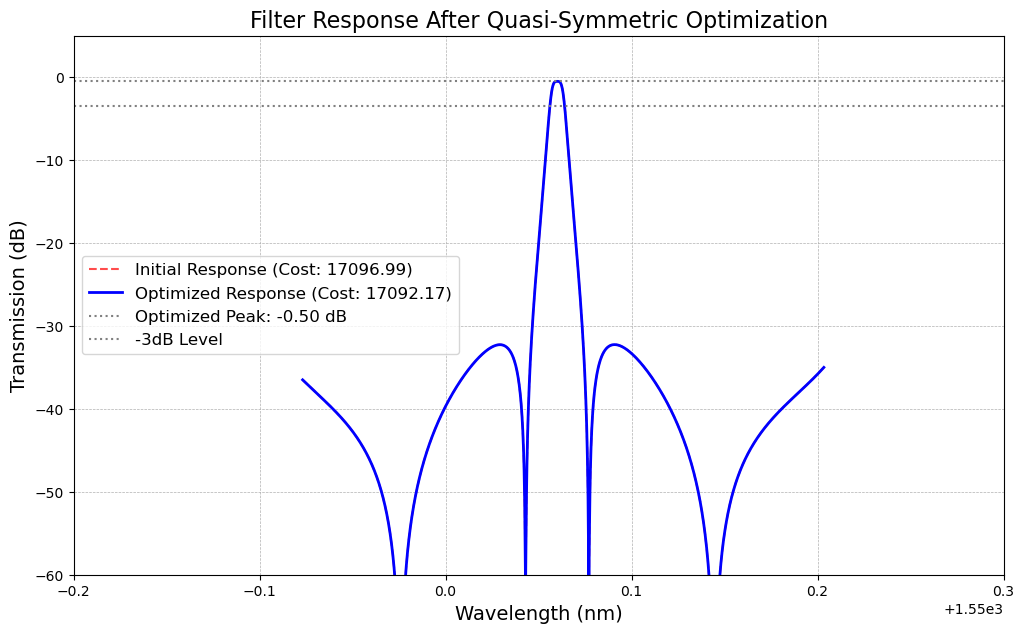

In [13]:
# === SECTION 1: IMPORTS AND SETUP ===

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Configuration: Define your targets and weights here ---
# This is the main section for user adjustments.
TARGETS = {
    'center_wavelength_nm': 1550.05,
    'bandwidth_ghz': 25.0,
    'rejection_db': -40.0
}

WEIGHTS = {
    'insertion_loss': 10.0,
    'ripple': 200.0,
    'bw_error': 50.0,
    'cf_error': 50.0,
    'shape_factor': 100.0,
    'rejection': 5.0
}


# === SECTION 2: CORE SIMULATION AND COST FUNCTIONS ===

def run_simulation(params, static_params):
    """
    Run the optical filter simulation.
    This function takes the parameters and simulates the physical response.
    """
    # --- Unpack parameters ---
    f = static_params['f']
    c = static_params['c']
    fai1, fai2, fai3, fai4, theta1, theta2, theta3, theta4 = params
    
    # Unpack fixed device properties
    E1, E2 = 0, 1
    Ki, Ko = 0.5, 0.5
    thetai, thetao = 0.5 * np.pi, 0.5 * np.pi
    fait, faib = 0.495 * np.pi, -0.495 * np.pi
    Alfadb, ng = 15, 4.3
    L1, L2, L3, L4 = 350e-6, 3000e-6, 350e-6, 3000e-6

    # --- Preliminary calculations ---
    alfa = (Alfadb / 2) * np.log(10) / 10
    tao1 = np.exp(-alfa * L1)
    tao2 = np.exp(-alfa * L2)
    tao3 = np.exp(-alfa * L3)
    tao4 = np.exp(-alfa * L4)

    # --- Core simulation logic ---
    fai11 = 2 * np.pi * f * L1 * ng / c
    fai22 = 2 * np.pi * f * L2 * ng / c
    fai33 = 2 * np.pi * f * L3 * ng / c
    fai44 = 2 * np.pi * f * L4 * ng / c
    
    E3 = np.sqrt(1 - Ki) * E1 - 1j * np.sqrt(Ki) * E2
    E4 = -1j * np.sqrt(Ki) * E1 + np.sqrt(1 - Ki) * E2
    
    E5 = E3
    E6 = np.exp(1j * thetai) * E4
    
    E7 = np.sqrt(1 - Ki) * E5 - 1j * np.sqrt(Ki) * E6
    E8 = -1j * np.sqrt(Ki) * E5 + np.sqrt(1 - Ki) * E6
    
    # Nicely formatted long lines for resonator transfer functions
    c1_num = (np.exp(1j * theta1) - 1) / 2 - tao1 * np.exp(1j * (fai1 + theta1 + fai11))
    c1_den = 1 - tao1 * (1 - np.exp(1j * theta1)) * np.exp(1j * (fai11 + fai1)) / 2
    c1 = c1_num / c1_den
    
    c2_num = (np.exp(1j * theta2) - 1) / 2 - tao2 * np.exp(1j * (fai2 + theta2 + fai22))
    c2_den = 1 - tao2 * (1 - np.exp(1j * theta2)) * np.exp(1j * (fai22 + fai2)) / 2
    c2 = c2_num / c2_den

    c3_num = (np.exp(1j * theta3) - 1) / 2 - tao3 * np.exp(1j * (fai3 + theta3 + fai33))
    c3_den = 1 - tao3 * (1 - np.exp(1j * theta3)) * np.exp(1j * (fai33 + fai3)) / 2
    c3 = c3_num / c3_den

    c4_num = (np.exp(1j * theta4) - 1) / 2 - tao4 * np.exp(1j * (fai4 + theta4 + fai44))
    c4_den = 1 - tao4 * (1 - np.exp(1j * theta4)) * np.exp(1j * (fai44 + fai4)) / 2
    c4 = c4_num / c4_den
    
    A1 = np.exp(1j * fait) * c1 * c2
    A2 = np.exp(1j * faib) * c3 * c4
    
    E9 = A1 * E7
    E10 = A2 * E8
    
    E11 = np.sqrt(1 - Ko) * E9 - 1j * np.sqrt(Ko) * E10
    E12 = -1j * np.sqrt(Ko) * E9 + np.sqrt(1 - Ko) * E10
    
    E13 = E11
    E14 = np.exp(1j * thetao) * E12
    
    E15 = np.sqrt(1 - Ko) * E13 - 1j * np.sqrt(Ko) * E14
    E16 = -1j * np.sqrt(Ko) * E13 + np.sqrt(1 - Ko) * E14
    
    # Add a small epsilon to prevent log10(0) error
    C2 = np.abs(E16)**2 + 1e-12
    CdB2 = 10 * np.log10(C2)
    lambda_nm = (c / f) * 1e9
    
    return lambda_nm, CdB2


def cost_function(params, static_params, targets, weights):
    """
    Calculates the cost (penalty) for a given set of parameters.
    The optimizer's goal is to minimize this value.
    """
    lambda_nm, CdB2 = run_simulation(params, static_params)
    c = static_params['c']

    # --- Analyze the simulation result ---
    peak_val = np.max(CdB2)
    peak_idx = np.argmax(CdB2)
    peak_lambda = lambda_nm[peak_idx]

    target_bw_nm = targets['bandwidth_ghz'] * 1e9 * targets['center_wavelength_nm']**2 / c
    passband_mask = np.abs(lambda_nm - peak_lambda) <= (target_bw_nm / 2)
    stopband_mask = np.abs(lambda_nm - peak_lambda) > (2 * target_bw_nm)

    # --- Calculate individual penalty values ---
    
    # Penalty 1: Insertion Loss
    penalty_loss = (-peak_val)**2 if peak_val < 0 else 0
    
    # Penalty 2: Passband Ripple
    passband_db = CdB2[passband_mask]
    penalty_ripple = np.max(passband_db) - np.min(passband_db) if passband_db.size > 0 else 100

    # Penalties 3 & 4: Bandwidth and Center Frequency Error
    try:
        def find_bw_points(x_data, y_data, peak_y, peak_x_idx, level_db):
            y_level = peak_y - level_db
            left_y, right_y = y_data[:peak_x_idx + 1], y_data[peak_x_idx:]
            if y_level < min(left_y) or y_level < min(right_y): raise ValueError("Level is below data range")
            x_level_l = np.interp(y_level, left_y, x_data[:peak_x_idx + 1])
            x_level_h = np.interp(y_level, right_y[::-1], x_data[peak_x_idx:][::-1])
            return x_level_l, x_level_h
        
        x_3db_l, x_3db_h = find_bw_points(lambda_nm, CdB2, peak_val, peak_idx, 3)
        actual_bw_ghz = abs(c / (x_3db_l * 1e-9) - c / (x_3db_h * 1e-9)) / 1e9
        
        penalty_bw_error = ((actual_bw_ghz - targets['bandwidth_ghz']) / targets['bandwidth_ghz'])**2
        penalty_cf_error = ((peak_lambda - targets['center_wavelength_nm']) / target_bw_nm)**2
    except (ValueError, IndexError):
        actual_bw_ghz = 0
        penalty_bw_error = 100
        penalty_cf_error = 100

    # Penalty 5: Shape Factor
    try:
        x_10db_l, x_10db_h = find_bw_points(lambda_nm, CdB2, peak_val, peak_idx, 10)
        actual_10db_bw_ghz = abs(c / (x_10db_l * 1e-9) - c / (x_10db_h * 1e-9)) / 1e9
        shape_factor = actual_10db_bw_ghz / actual_bw_ghz if actual_bw_ghz > 0 else 100
        penalty_shape_factor = (shape_factor - 1)**2
    except (ValueError, IndexError):
        penalty_shape_factor = 100

    # Penalty 6: Out-of-band Rejection
    avg_rejection = np.mean(CdB2[stopband_mask]) if stopband_mask.size > 0 else 0
    penalty_rejection = max(0, avg_rejection - targets['rejection_db'])
        
    # --- Calculate the final weighted cost ---
    total_cost = (
        weights['insertion_loss'] * penalty_loss +
        weights['ripple'] * penalty_ripple +
        weights['bw_error'] * penalty_bw_error +
        weights['cf_error'] * penalty_cf_error +
        weights['shape_factor'] * penalty_shape_factor +
        weights['rejection'] * penalty_rejection
    )
    
    return total_cost


# === SECTION 3: QUASI-SYMMETRIC WRAPPER FUNCTION ===

def objective_wrapper_quasi_symmetric(base_params, static_params, targets, weights):
    """
    This wrapper takes 6 base parameters, constructs the full 8 quasi-symmetric
    parameters, and then calls the original cost function.
    """
    # p_... are the 6 parameters we are actually optimizing
    (
        theta_outer, theta_inner, 
        fai_outer_center, fai_outer_perturb, 
        fai_inner_center, fai_inner_perturb
    ) = base_params
    
    # Construct the full 8-parameter set based on the quasi-symmetric model
    full_params = [
        fai_outer_center + fai_outer_perturb,  # fai1
        fai_inner_center + fai_inner_perturb,  # fai2
        fai_outer_center - fai_outer_perturb,  # fai3 (Symmetric about a center)
        fai_inner_center - fai_inner_perturb,  # fai4 (Symmetric about a center)
        theta_outer,                           # theta1
        theta_inner,                           # theta2
        theta_outer,                           # theta3 (Perfectly symmetric)
        theta_inner                            # theta4 (Perfectly symmetric)
    ]
    
    return cost_function(full_params, static_params, targets, weights)


# === SECTION 4: MAIN EXECUTION AND VISUALIZATION ===

# --- Prepare for optimization ---
static_params = {
    'f': np.arange(1.93523e14, 1.93558e14, 0.0000001e14),
    'c': 3e8
}

# --- Define initial guess and bounds for the 6 quasi-symmetric parameters ---
# We derive these guesses from your original MATLAB code
initial_base_params = [
    -0.622 * np.pi,                            # theta_outer (base value for theta1/3)
    -0.730 * np.pi,                            # theta_inner (base value for theta2/4)
    (-0.0468 - 0.0518) / 2 * np.pi,            # fai_outer_center (avg of fai1 and fai3)
    (-0.0468 - (-0.0518)) / 2 * np.pi,         # fai_outer_perturb (half diff of fai1 and fai3)
    (-0.6842 - 0.6198) / 2 * np.pi,            # fai_inner_center (avg of fai2 and fai4)
    (-0.6842 - (-0.6198)) / 2 * np.pi          # fai_inner_perturb (half diff of fai2 and fai4)
]

# Define bounds, giving tight constraints to the perturbation terms
bounds_6d = [
    (-np.pi, np.pi),      # theta_outer
    (-np.pi, np.pi),      # theta_inner
    (-np.pi, np.pi),      # fai_outer_center
    (-0.1 * np.pi, 0.1 * np.pi), # fai_outer_perturb (should be small)
    (-np.pi, np.pi),      # fai_inner_center
    (-0.1 * np.pi, 0.1 * np.pi)  # fai_inner_perturb (should be small)
]

# --- Check initial performance ---
print("--- Initial Parameters Performance ---")

initial_full_params = [
    initial_base_params[2] + initial_base_params[3], 
    initial_base_params[4] + initial_base_params[5],
    initial_base_params[2] - initial_base_params[3], 
    initial_base_params[4] - initial_base_params[5],
    initial_base_params[0], 
    initial_base_params[1], 
    initial_base_params[0], 
    initial_base_params[1]
]
lambda_nm_initial, CdB2_initial = run_simulation(initial_full_params, static_params)
initial_cost = cost_function(initial_full_params, static_params, TARGETS, WEIGHTS)

print(f"Initial Cost: {initial_cost:.4f}")


# --- Start Optimization ---
print("\n--- Starting Quasi-Symmetric Optimization... ---")

result = minimize(
    fun=objective_wrapper_quasi_symmetric,
    x0=initial_base_params,
    args=(static_params, TARGETS, WEIGHTS),
    method='L-BFGS-B',
    bounds=bounds_6d,
    options={'disp': True, 'maxiter': 300, 'ftol': 1e-10, 'gtol': 1e-8}
)


# --- Display Optimization Results ---
print("\n--- Optimization Finished ---")
print(f"Success: {result.success}")
print(f"Final Cost: {result.fun:.4f}")
print("Optimal Base Parameters Found (6 values):")

p_names = [
    'theta_outer', 'theta_inner', 
    'fai_outer_center', 'fai_outer_perturb', 
    'fai_inner_center', 'fai_inner_perturb'
]
for name, val in zip(p_names, result.x):
    print(f"  {name}: {val:.6f}")


# --- Visualize the Comparison ---
print("\n--- Generating Comparison Plot... ---")

# Construct the final 8 parameters from the 6 optimized base ones
obp = result.x
optimized_full_params = [
    obp[2] + obp[3], obp[4] + obp[5], 
    obp[2] - obp[3], obp[4] - obp[5],
    obp[0], obp[1], obp[0], obp[1]
]
lambda_nm_opt, CdB2_opt = run_simulation(optimized_full_params, static_params)

plt.figure(figsize=(12, 7))

plt.plot(
    lambda_nm_initial, CdB2_initial, 'r--', 
    label=f'Initial Response (Cost: {initial_cost:.2f})', 
    alpha=0.7
)
plt.plot(
    lambda_nm_opt, CdB2_opt, 'b-', 
    label=f'Optimized Response (Cost: {result.fun:.2f})', 
    linewidth=2
)

peak_opt = np.max(CdB2_opt)
plt.axhline(y=peak_opt, color='gray', linestyle=':', label=f'Optimized Peak: {peak_opt:.2f} dB')
plt.axhline(y=peak_opt - 3, color='gray', linestyle=':', label='-3dB Level')

plt.title('Filter Response After Quasi-Symmetric Optimization', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Transmission (dB)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(-60, 5)
plt.xlim(TARGETS['center_wavelength_nm'] - 0.25, TARGETS['center_wavelength_nm'] + 0.25)

plt.show()